In [24]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import clip
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Dataset**

In [25]:
from VQA_Datasetv2 import VQA_Dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

dataset = VQA_Dataset()
dataset.load_all(preprocess, length=200, device=device)

#Testing dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

for element in tqdm(dataloader, desc="Testing"):
    id = element['image_id']
    if id == 26216:
        print(element["question"])#, "question: ", i['question_tokens'], "answer: ", i['answer_tokens'])

Testing: 100%|██████████| 200/200 [00:00<00:00, 5259.45it/s]

['Is the man tell the girl to slide down?']
["Is the man old enough to be the girl's grandfather?"]
['What color is the slide?']


**Test-train split**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train size:  160
Test size:  40


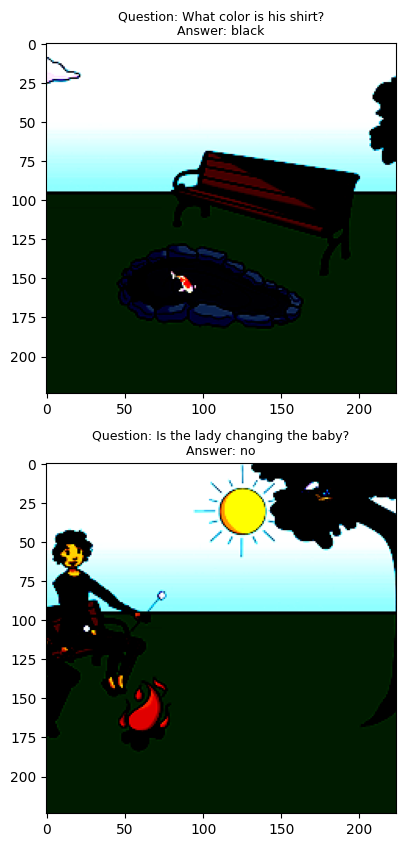

In [26]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset)*0.8)
test_size = int(len(dataset))-train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print("Train size: ", train_size)
print("Test size: ", test_size)

batch_size=2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#Checking data
fig=plt.figure(0, (18, 10))
for element in train_dataloader:
    for i in range(batch_size):
        ax = fig.add_subplot(2,int(batch_size/2),i+1)
        ax.imshow(np.transpose(element["image"][i].cpu(), (1, 2, 0))) #Converting to matplotlib format
        ax.set_title("Question: "+str(element["question"][i])+"\nAnswer: "+str(element["correct_answer_text"][i]), fontsize=9)
    break

**Model**

In [27]:
from torch import nn
from torch.nn import Flatten, Conv2d, Linear, ReLU, Dropout, MaxPool2d
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs')
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else b"cpu"#mps stands for matrix product states, basically enables high-performance training
print("Using: ", device)

#CLIP
clip_model, preprocess = clip.load('ViT-B/32', device)

Using:  cuda


In [28]:
import os
from PIL import Image
from torchvision import transforms

img = Image.open(os.path.join("Images", "abstract_v002_val2015_000000029903.png"))
image_input = preprocess(img).unsqueeze(0).to(device)
print("Image preprocessed: ",image_input.shape)

image_features = clip_model.encode_image(image_input)
print("Image encoded size: ", image_features.shape)

text = clip.tokenize(["a diagram of the dof" , "a dog", "a cat"]).to(device)
print("Text tokenized size: ",text.shape)

text_features = clip_model.encode_text(text)
print("Text encoded size: ",text_features.shape)

Image preprocessed:  torch.Size([1, 3, 224, 224])
Image encoded size:  torch.Size([1, 512])
Text tokenized size:  torch.Size([3, 77])
Text encoded size:  torch.Size([3, 512])


In [29]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.ReLU = ReLU()
        self.fc1 = Linear(in_features=512*2, out_features=512)

    def forward(self, x):
        out = self.fc1(x)
        return out

vqaModel = model().to(device)
#writer.add_graph(terrenatorModel,images.to("cuda:0"))
#writer.close()

**Optim**

In [30]:
loss_fn = nn.CrossEntropyLoss()#Hace el softmax y la funcion costo al mismo tiempo
optimizer = torch.optim.Adam(vqaModel.parameters(), lr=1e-3)

In [33]:
def train(dataloader, vqaModel, loss_function, optimizer, epoch):
    size = len(dataloader.dataset)
    vqaModel.train()
    for batch, (data) in enumerate(dataloader):
        x1_preclip = data["question_tokens"].permute(1,0,2).squeeze(0)
        x2_preclip = data["image"]
        
        x1 = clip_model.encode_text(x1_preclip)
        x2 = clip_model.encode_image(x2_preclip)
        x = torch.cat((x1, x2), dim=1).to(torch.float32)
        #print(x.shape): (batch, 1024)

        nn_output = vqaModel(x)

        #Calculating
        answers_tokens = data["answer_tokens"]        
        answers_encoded = torch.stack([clip_model.encode_text(batch_answers_tokens) for batch_answers_tokens in answers_tokens])
        
        nn_output /= nn_output.clone().norm(dim=-1, keepdim=True)
        answers_encoded /= answers_encoded.clone().norm(dim=-1, keepdim=True)

        similarity = 100*torch.einsum("bn,bqn->bq", [nn_output, answers_encoded.to(torch.float32)])  #b stands for # of batches, n for size embedding(512) and q number of possible_answers
        similarity_pred = similarity.softmax(dim=-1)

        arg = torch.argmax(similarity, dim=-1)
        similarity_label = torch.nn.functional.one_hot(arg, num_classes=18).to(torch.float32)

        loss = loss_fn(similarity_pred, similarity_label)

        # writer.add_scalar("Loss/train", loss, epoch)

        # #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

        if batch % 2 == 0:
            loss, current = loss.item(), batch*len(x)
            print("loss: ", loss, current, size)

train(train_dataloader, vqaModel, loss_fn, optimizer, 5)

loss:  2.0048608779907227 0 160
loss:  2.3289756774902344 4 160
loss:  2.021702527999878 8 160
loss:  2.285598039627075 12 160
loss:  2.2534942626953125 16 160
loss:  2.0953245162963867 20 160
loss:  2.371673107147217 24 160
loss:  2.404844045639038 28 160
loss:  2.0899457931518555 32 160
loss:  2.0375289916992188 36 160
loss:  2.0245485305786133 40 160
loss:  2.3168044090270996 44 160
loss:  2.0085501670837402 48 160
loss:  2.1809911727905273 52 160
loss:  1.9844518899917603 56 160
loss:  1.9815582036972046 60 160
loss:  2.093536853790283 64 160
loss:  2.181687831878662 68 160
loss:  2.102156162261963 72 160
loss:  2.0202202796936035 76 160
loss:  1.9858185052871704 80 160
loss:  2.4059765338897705 84 160
loss:  2.2886109352111816 88 160
loss:  2.276400327682495 92 160
loss:  2.191654682159424 96 160
loss:  2.1405272483825684 100 160
loss:  2.0792975425720215 104 160
loss:  2.2900876998901367 108 160
loss:  2.189760446548462 112 160
loss:  1.982740044593811 116 160
loss:  2.2144086360

In [ ]:
def test(dataloader, model, loss_function,t):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    writer.add_scalar('test accuracy', correct*100, t)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")